Slow version of gensim.models.doc2vec is being used
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Number of relevant pixels =  66


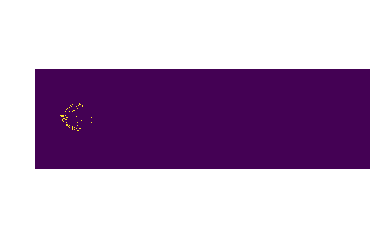

In [1]:
# FOR EACH DATASET SHOWS HOW SIMILAR EACH PIXEL IS TO THE SELECTED REGION

# SET SUMFORMULA NAME, ADDUCT, DATASET for selecting the region
sf = 'C6H9NO5'
adduct = '+Na'
ds_name = 'wb xenograft in situ metabolomics test - rms_corrected'

# model param : tfidf or lsi or corpus
model = "tfidf"
# quantile param
q = 99.5

import os
from os import path
import pandas as pd
import gensim
from gensim import corpora
import pickle
import numpy as np
from IPython.display import Image, display

base_path = '/opt/data/'
ann_path = path.join(base_path, 'pixel-annot-export')
cor_path = path.join(base_path, 'pixel-corpora/pixel_'+model+'.mm')
sim_path = os.path.join(base_path,'pixel_similarity_models/'+model+'.index')
map_path = path.join(base_path, 'pixel-ind2ord')

ds_df_path = path.join(ann_path, 'ds_df.msgpack')
ds_df = pd.read_msgpack(ds_df_path)
ds_ind = ds_df[ds_df['name'] == ds_name].index.tolist()[0]

ion_df_path = path.join(ann_path, 'ion_df.msgpack')
ion_df = pd.read_msgpack(ion_df_path)
ion_ind = ion_df[ion_df.formula == sf][ion_df.adduct == adduct].index.tolist()[0]

pind2ord_path = path.join(map_path, '{}.pkl'.format(ds_ind))
with open(pind2ord_path, 'rb') as f: pind2ord = pickle.load(f)

pixel_df_path = path.join(ann_path, 'pixel_df_list/{}.msgpack'.format(ds_ind))
pixel_df = pd.read_msgpack(pixel_df_path)

int = np.percentile(pixel_df.int.tolist(), q)
ion_sub_df = pixel_df[(pixel_df.ion_ind == ion_ind) & (pixel_df.int > int)]
region_pixel_ids = [pind2ord[i] for i in ion_sub_df.p_ind.unique() if i in pind2ord]

print('Number of relevant pixels = ', len(region_pixel_ids))

%matplotlib inline
import matplotlib.pyplot as plt

max_x = pixel_df['x'].max()
max_y = pixel_df['y'].max()
arr = np.zeros([max_x+1, max_y+1])

for index, row in ion_sub_df.iterrows():
    arr[row['x'].astype(np.int64)][row['y'].astype(np.int64)] = 1
arr = np.rot90(arr, 1)

plt.pcolormesh(arr,cmap='viridis')
plt.axes().set_aspect('equal', 'datalim')
plt.axes().axis('off')
plt.show()

In [2]:
import gensim
from gensim import corpora
from gensim import similarities
from gensim.similarities import Similarity
from datetime import datetime

corpus = gensim.corpora.MmCorpus(cor_path)

def average_weight4group(doc_ids,corpus):
    id2v = {}
    for di in doc_ids:
        for (i,v) in corpus[di]:
            if not i in id2v: id2v[i] = []
            id2v[i].append(v)
    return [(i,np.mean(id2v[i])) for i in id2v]

query_bow = average_weight4group(region_pixel_ids,corpus)
print(str(datetime.now()) + ': query_bow generated')

sim_index = Similarity.load(sim_path)
sim_corpus = sim_index[query_bow]
print(str(datetime.now()) + ': sim_corpus generated')

2017-06-26 13:26:53.726273: query_bow generated
2017-06-26 13:28:51.057327: sim_corpus generated


In [7]:
# PUT HERE ONLY THOSE DATASETS THAT YOU WANT TO COMPARE. IF EMPTY THEN OUTPUTS ALL OF THEM
onlydatasets = [] #['WB_tumor_zoom_08042015_vehicle','U Rennes 1//mouse_brain_dithranol_03 - root mean square']

smin = sim_corpus.min(axis=0)
smax = sim_corpus.max(axis=0)

print("Similarity min = %f, max = %f" % (smin, smax))

genpics_path = path.join(base_path, '/home/ec2-user/Metabol/genpics/simpics_'+model)
for f in os.listdir(genpics_path): os.remove(path.join(genpics_path,f))

pa_path = path.join(base_path, 'pixel-annot-export/pixel_df_list')
fileinds = [np.int16(f.split('.')[0]) for f in os.listdir(pa_path)]

ds_names = []

for fileind in fileinds:
    ds_name = ds_df.get_value(fileind,'name')
    
    if len(onlydatasets)>0 and ds_name not in onlydatasets: continue
    
    df = pd.read_msgpack(path.join(pa_path, '{}.msgpack'.format(fileind)))
    with open(path.join(map_path, '{}.pkl'.format(fileind)), 'rb') as f: pind2ord = pickle.load(f)
   
    max_x = df['x'].max()
    max_y = df['y'].max()
    arr = np.zeros([max_x+1, max_y+1])

    for _, pixel_df in df.groupby('p_ind'):
        p_ind = pixel_df['p_ind'].tolist()[0]
        if p_ind in pind2ord:
            x = pixel_df['x'].tolist()[0]
            y = pixel_df['y'].tolist()[0]
            arr[x][y] = sim_corpus[pind2ord[p_ind]]

    a_max = arr.max()
    if (a_max-arr.min()) == 0: continue
        
    print(ds_name)
    ds_names.append((ds_name, a_max))
           
    arr = np.rot90(arr, 1)
    
    #plt.pcolormesh(arr, vmin=smin, vmax=smax, cmap='viridis')
    plt.pcolormesh(arr, cmap='viridis')
    plt.axes().set_aspect('equal', 'datalim')
    plt.axes().axis('off')
    plt.title(ds_name)
    plt.colorbar()
    ds_name = ds_name.replace('/','!')
    ds_name = ds_name.replace('.',',')
    i_path = path.join(genpics_path,ds_name)
    plt.savefig(i_path, bbox_inches='tight')
    plt.clf()

print(str(datetime.now()) + ' Number of images generated = '  + str(len(ds_names)))

Similarity min = 0.000000, max = 0.988716
Dataset 9
100314_Echin_Esco2b_centroids
20161223_ADP_larvae_DHB008_380x160_20x20
UoR1//16ag01475_02d
mouse_brain_dithranol_02 - root mean square
20161216_LR_sample1_dhb10_rec1_space25_att35_rep3_20x20
NCSU_macaque_colon
100314_Echin_Trich_centroids
Dataset 15
Dataset 5
MK 12
KS_24_5_6_7
Rat41_Section1
20170329_LR_HEPA_DHB10_p40x40_s50x50_1
0500240A3+
UoR1//Brain02_Bregma-1-46
dosedRatBrain
Spectroswiss//sol_2x_br_1
mouse_brain_dhb_03 - root mean square
20170111_KR_Exp11_850_DOX_pos_25x30_10x10
0500049A5+
MPIMM_054_QE_P_BP_CF
MPIMM_047_QE_P_BA_CF_sp1
U Rennes 1//mouse_brain_dithranol_03 - root mean square
0900229A8+
servier_TT_mouse_wb_fmpts_derivatization_CHCA
Pinus_Root
20161216_LR_sample1_dhb10_rec0_space50_att40_rep1_20x20
170321_kangaroobrain-dan2-pos_maxof50.0_med1
Dataset 20
U Rennes 1//head2_region3 - root mean square
head1_region1 - root mean square
20170425_ADP_7-8-9-10_250lyst2_250spciA1_250K15C1_250hisD1_200x200_122x195_P_17042515564

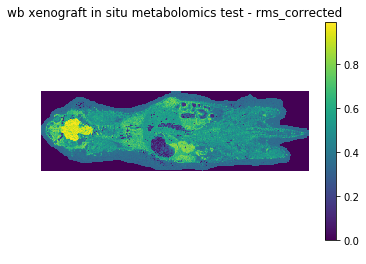

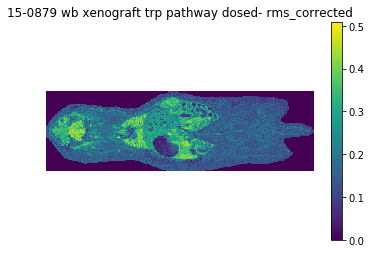

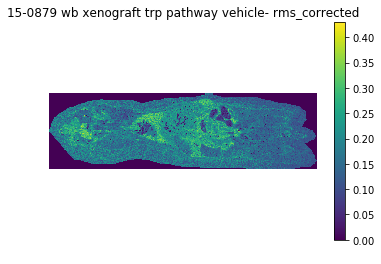

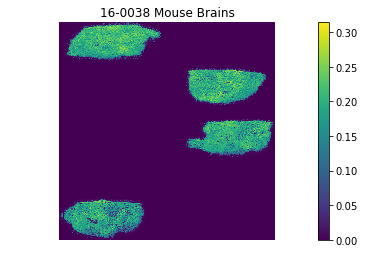

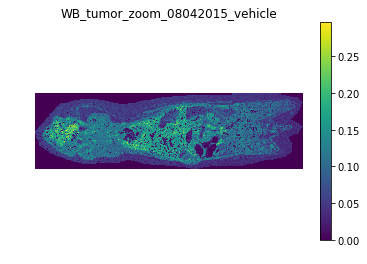

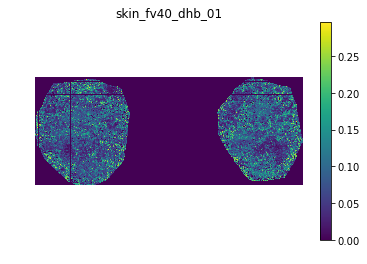

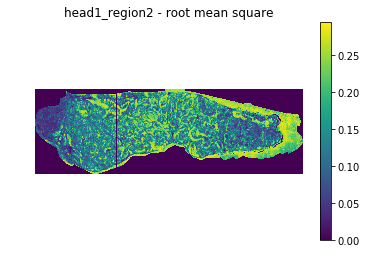

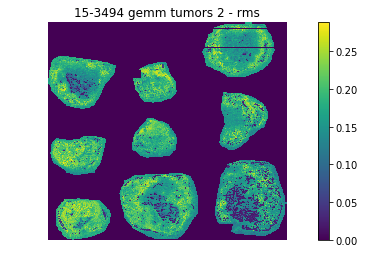

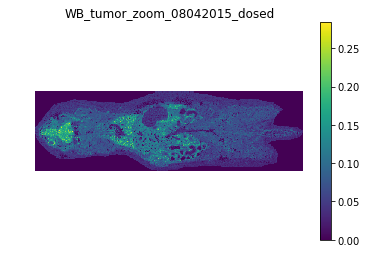

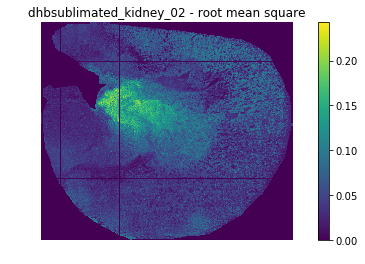

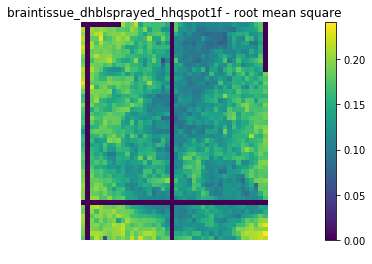

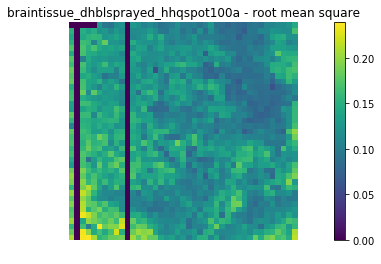

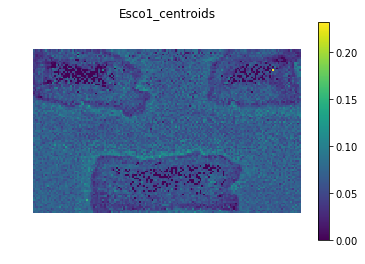

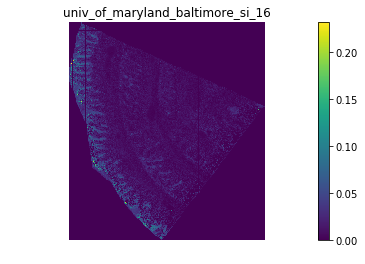

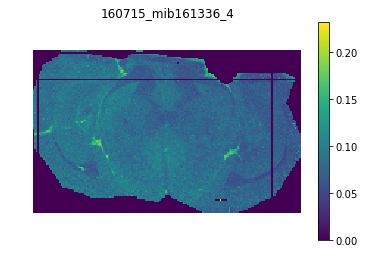

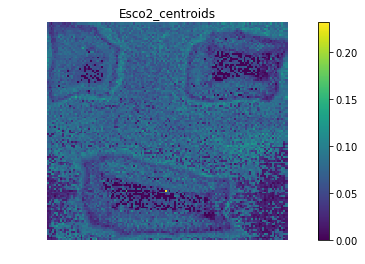

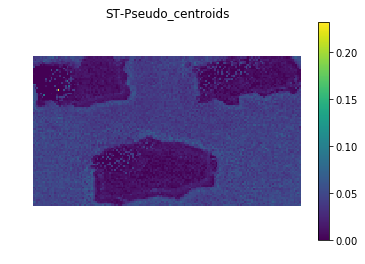

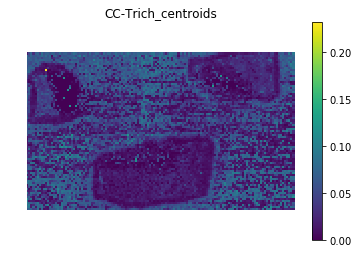

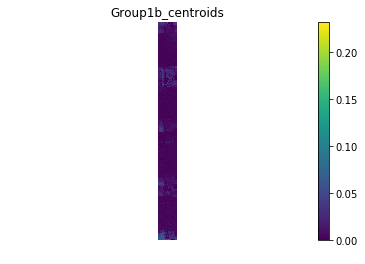

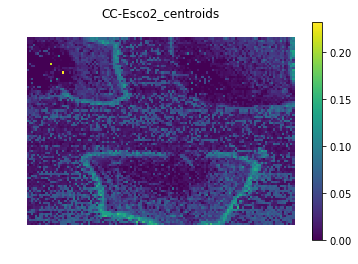

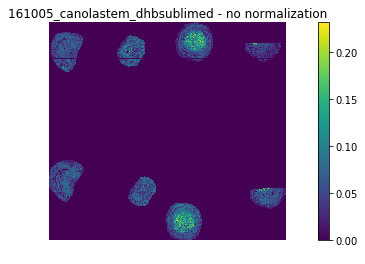

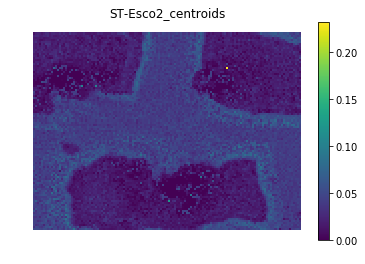

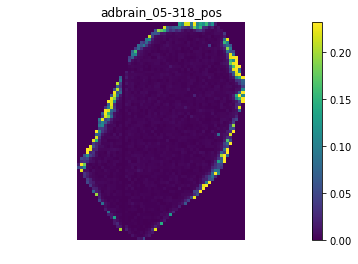

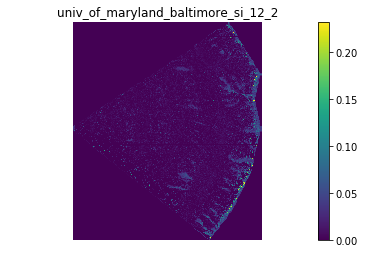

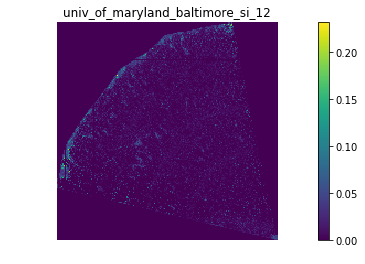

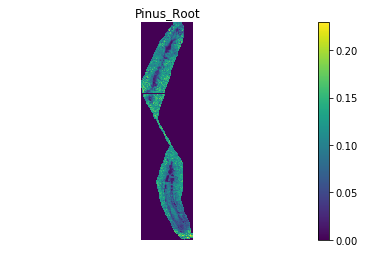

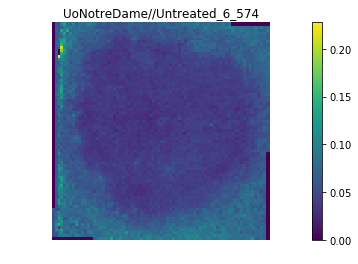

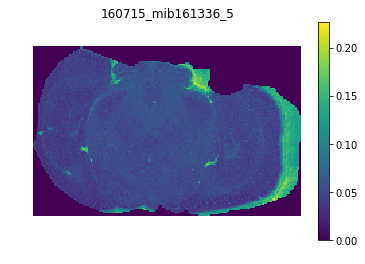

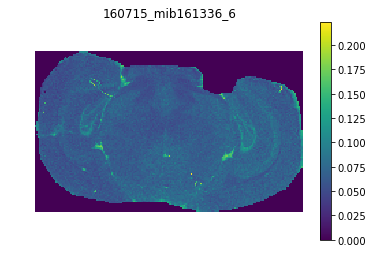

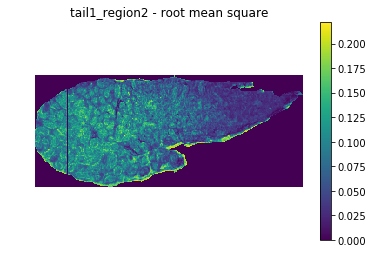

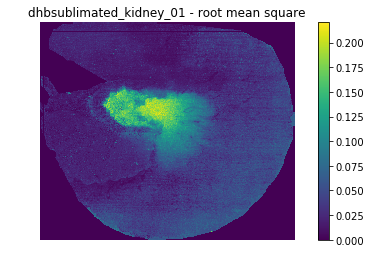

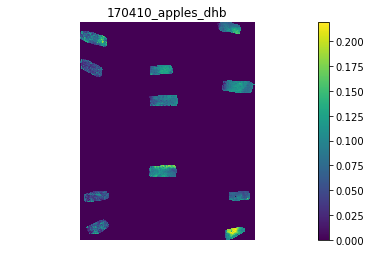

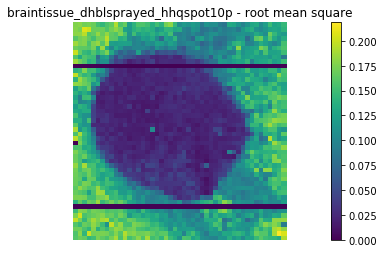

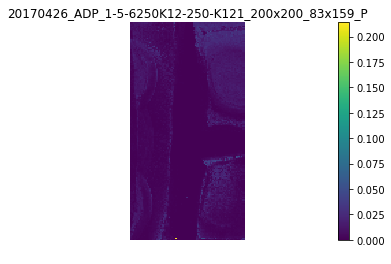

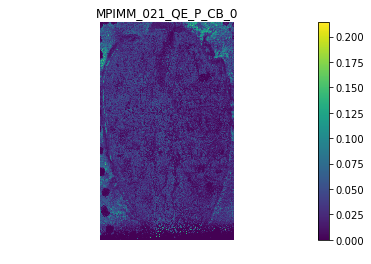

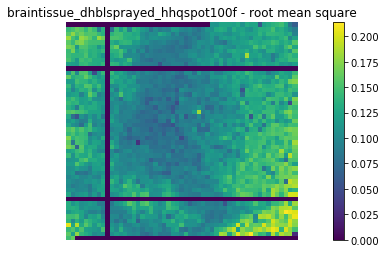

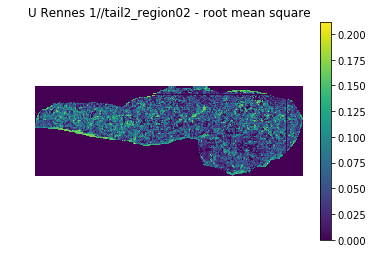

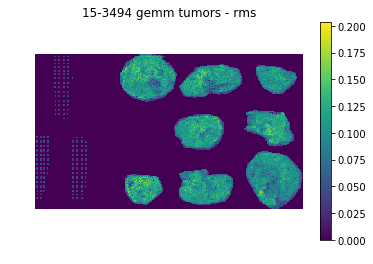

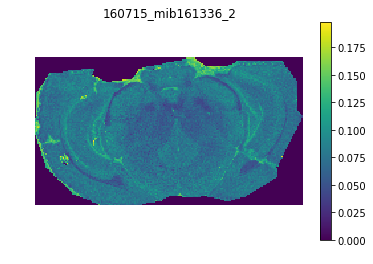

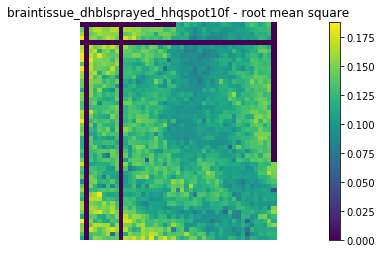

In [9]:
# HOW MANY DATASETS WITH A HIGHEST SIMILARITY PIXEL TO DISPLAY, PUT 10000 to DISPLAY ALL
max_sim_numb = 40
# DATASET NAMES TO BE DISPLAYED (from the list above)
onlydatasets = []
#['WB_tumor_zoom_08042015_vehicle','servier_TT_mouse_wb_fmpts_derivatization_CHCA','15-0879 wb xenograft trp pathway dosed- rms_corrected','wb xenograft in situ metabolomics test - rms_corrected','WBMouseAniline']

genpics_path = path.join(base_path, '/home/ec2-user/Metabol/genpics/simpics_'+model)

if max_sim_numb > len(ds_names): max_sim_numb = len(ds_names)

if len(onlydatasets)==0:
    ds_names.sort(key=lambda x: x[1],reverse=True)
    onlydatasets = [ds_names[i][0] for i in range(0,max_sim_numb)]
        
for ds_name in onlydatasets:
    ds_name = ds_name.replace('/','!')
    ds_name = ds_name.replace('.',',')
    i_path = path.join(genpics_path, ds_name+'.png')
    if path.isfile(i_path):
        display(Image(filename=i_path))
    else: print('No image for ', ds_name)